# Nonlinear SVM Classification

## About Dataset

`make_moons` toy dataset for binary classification

## Import Libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from scipy.stats import mode
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression

## Import Dataset

In [15]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

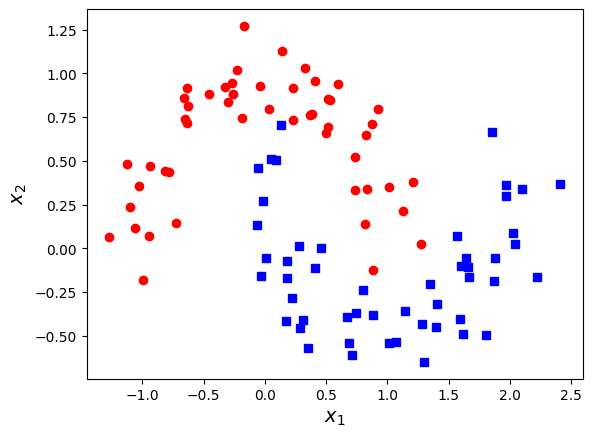

In [16]:
# Plot make_moons dataset
def plot_dataset(X, y):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
    plt.xlabel(r"$x_1$", fontsize=14)
    plt.ylabel(r"$x_2$", fontsize=14)

plot_dataset(X, y)
plt.show()

## Create Pipeline

In [4]:
# Pipeline will contain PolynomialFeatures, StandardScaler and LinearSVC
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge"))
])

# Fit data
polynomial_svm_clf.fit(X, y)

C:\Users\ttomk\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

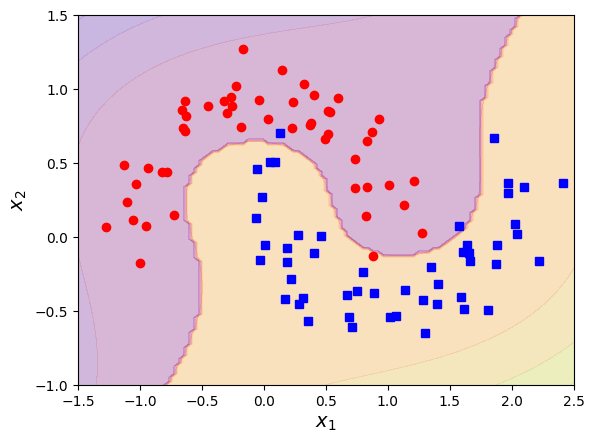

In [5]:
# Compute predictions and plot data with Linear SVM classifier using polynomial features
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.plasma, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y)
plt.show()

## Kernel Trick

In [6]:
# Create pipeline using StandardScaler and SVC with 3rd degree polynomial kernel and hyperparameter coef0 = 1
poly_kernel_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])
poly_kernel_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [7]:
# Create pipeline using StandardScaler and SVC with 10th degree polynomial kernel and hyperparameter coef0 = 100
poly100_kernel_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
])
poly100_kernel_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

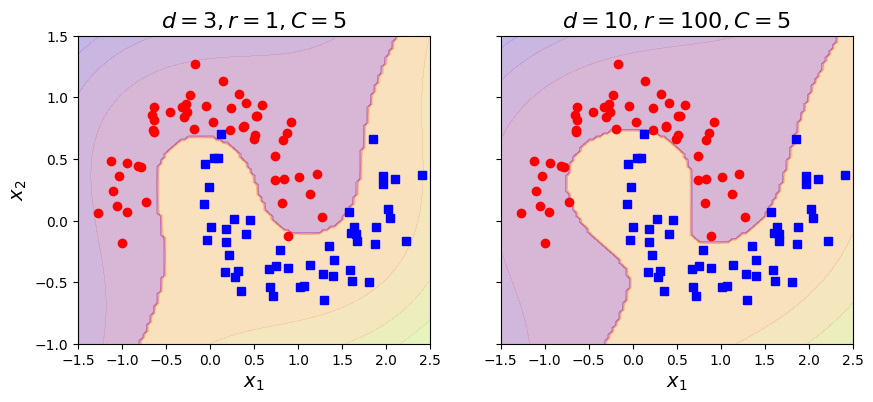

In [8]:
# Plot SVM classifiers with a polynomial kernel
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_dataset(X, y)
plot_predictions(poly_kernel_clf, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=16)

plt.sca(axes[1])
plot_dataset(X, y)
plot_predictions(poly100_kernel_clf, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=16)
plt.ylabel("")
plt.show()

## Gaussian RBF Kernel

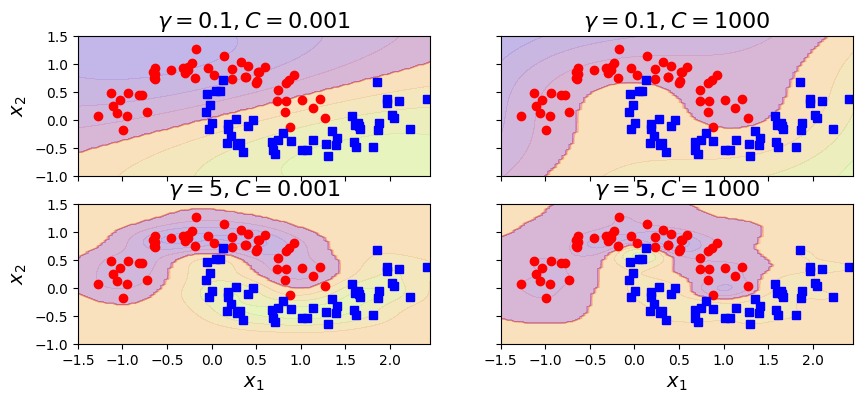

In [9]:
# Similar to polynomial features method Gaussian RBF kernel can be used
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
    ])
    rbf_kernel_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_clf)
    
# Plot SVM classifiers
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 4), sharex=True, sharey=True)
for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y)
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")
        
plt.show()        

The models are trained with different values of hyperparameters $\gamma$ and C. Increasing $\gamma$ the bell shaped curve becomes narrower (plots on the left) and as a result instances have smaller range of influence and the decision boundary is more irregular. $\gamma$ is like a regularization hyperparameter similar to C hyperparameter.

## Decision Tree Classifier

In [20]:
# Train Decision Tree without regularization
X, y = make_moons(n_samples=100, noise=0.15, random_state=53)
tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf1.fit(X, y)

DecisionTreeClassifier(random_state=42)

In [21]:
# Train Decision Tree with regularization using min_samples_leaf
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
tree_clf2.fit(X, y)

DecisionTreeClassifier(min_samples_leaf=4, random_state=42)

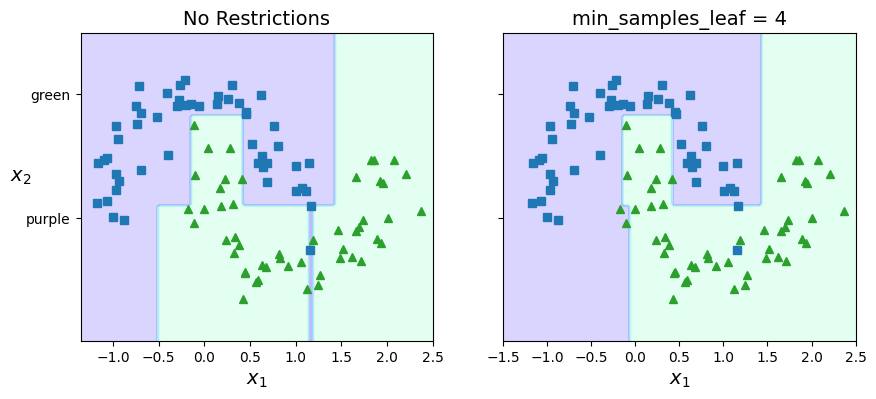

In [24]:
# Plot decision trees with and without restriction
def plot_decision_boundary(clf, X, y, legend=False, plot_train=True):
    X1s = np.linspace(-1.5, 2.5, 100)
    X2s = np.linspace(-1, 1.5, 100)
    X1, X2 = np.meshgrid(X1s, X2s)
    X_new = np.c_[X1.ravel(), X2.ravel()]
    y_pred = clf.predict(X_new).reshape(X1.shape)
    custom_cmap = ListedColormap(["#8576FF", "#7BC9FF", "#A3FFD6"])
    plt.contourf(X1, X2, y_pred, alpha=0.3, cmap=custom_cmap)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "s", "purple")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "^", "green")
    plt.xlabel(r"$x_1$", fontsize=14)
    plt.ylabel(r"$x_2$", fontsize=14, rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X, y)
plt.title("No Restrictions", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X, y)
plt.title("min_samples_leaf = {}".format(tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")
plt.show()

The model on the left is overfitting and the model on the right will probably generalize better.

### Fine Tune Decision Tree

In [13]:
# Select larger dataset
X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Find good hyperparameter values for Decision Tree
params = {"max_leaf_nodes": list(range(2, 100)), "min_samples_split": [2, 3, 4]}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=2, cv=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits
[CV] END ..............max_leaf_nodes=2, min_samples_split=2; total time=   0.0s
[CV] END ..............max_leaf_nodes=2, min_samples_split=2; total time=   0.0s
[CV] END ..............max_leaf_nodes=2, min_samples_split=2; total time=   0.0s
[CV] END ..............max_leaf_nodes=2, min_samples_split=3; total time=   0.0s
[CV] END ..............max_leaf_nodes=2, min_samples_split=3; total time=   0.0s
[CV] END ..............max_leaf_nodes=2, min_samples_split=3; total time=   0.0s
[CV] END ..............max_leaf_nodes=2, min_samples_split=4; total time=   0.0s
[CV] END ..............max_leaf_nodes=2, min_samples_split=4; total time=   0.0s
[CV] END ..............max_leaf_nodes=2, min_samples_split=4; total time=   0.0s
[CV] END ..............max_leaf_nodes=3, min_samples_split=2; total time=   0.0s
[CV] END ..............max_leaf_nodes=3, min_samples_split=2; total time=   0.0s
[CV] END ..............max_leaf_nodes=3, min_s

[CV] END .............max_leaf_nodes=17, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=17, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=18, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=18, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=18, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=18, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=18, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=18, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=18, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=18, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=18, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=19, min_samples_split=2; total time=   0.0s
[CV] END .............max_le

[CV] END .............max_leaf_nodes=31, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=31, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=31, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=31, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=31, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=31, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=31, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=31, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=32, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=32, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=32, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=32, min_samples_split=3; total time=   0.0s
[CV] END .............max_le

[CV] END .............max_leaf_nodes=43, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=43, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=43, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=43, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=43, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=43, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=43, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=44, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=44, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=44, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=44, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=44, min_samples_split=3; total time=   0.0s
[CV] END .............max_le

[CV] END .............max_leaf_nodes=54, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=54, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=54, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=55, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=55, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=55, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=55, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=55, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=55, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=55, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=55, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=55, min_samples_split=4; total time=   0.0s
[CV] END .............max_le

[CV] END .............max_leaf_nodes=66, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=66, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=66, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=66, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=66, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=66, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=66, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=67, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=67, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=67, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=67, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=67, min_samples_split=3; total time=   0.0s
[CV] END .............max_le

[CV] END .............max_leaf_nodes=81, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=81, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=81, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=81, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=81, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=81, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=81, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=81, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=82, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=82, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=82, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=82, min_samples_split=3; total time=   0.0s
[CV] END .............max_le

[CV] END .............max_leaf_nodes=95, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=95, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=95, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=95, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=95, min_samples_split=4; total time=   0.0s
[CV] END .............max_leaf_nodes=96, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=96, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=96, min_samples_split=2; total time=   0.0s
[CV] END .............max_leaf_nodes=96, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=96, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=96, min_samples_split=3; total time=   0.0s
[CV] END .............max_leaf_nodes=96, min_samples_split=4; total time=   0.0s
[CV] END .............max_le

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=2)

In [15]:
grid_search.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)

In [16]:
grid_search.best_score_

0.8555001986342105

In [17]:
# Compute accuracy of the model on the test set
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

### Grow a Forest

In [18]:
# Create 1000 subsets using ShuffleSplit class
n_trees = 1000
n_instances = 100

mini_set = []
rand_split = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rand_split.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_set.append((X_mini_train, y_mini_train))

In [19]:
# Train Decision Tree on each subset using the best hyperparameter values
forest = [clone(grid_search.best_estimator_) for _ in range(n_trees)]

# Find accuracy scores
accuracy_scores = []
for tree, (X_mini_train, y_mini_train) in zip(forest, mini_set):
    tree.fit(X_mini_train, y_mini_train)
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Compute average accuracy score
np.mean(accuracy_scores)

0.805471

In [20]:
# Find the majority-vote predictions over the test set
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)
    
y_pred_majority_votes, n_votes = mode(Y_pred, axis=0, keepdims=False)

In [21]:
# Evaluate predictions on the test set
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872

The accuracy score is slightly higher than 86.9% that was obtain using GridSearchCV.

## Voting Classifier

Compare `VotingClassifier` to individual classifiers such as `LogisticRegression`, `SVM` and `RandomForestClassifier` using `hard` and `soft` voting.

In [18]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
log_clf = LogisticRegression()
svm_clf = SVC()
rf_clf = RandomForestClassifier()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('svm', svm_clf), ('rf', rf_clf)],
    voting="hard")
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()), ('svm', SVC()),
                             ('rf', RandomForestClassifier())])

Check the accuracy score for each classifier.

In [4]:
for clf in (log_clf, svm_clf, rf_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
SVC 0.896
RandomForestClassifier 0.904
VotingClassifier 0.904


The voting classifier slightly outperforms all the individual classifiers. Check the performance using `soft` voting.

In [8]:
soft_voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('svm', svm_clf), ('rf', rf_clf)],
    voting="soft")
soft_voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()), ('svm', SVC()),
                             ('rf', RandomForestClassifier())],
                 voting='soft')

In [9]:
for clf in (log_clf, svm_clf, rf_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
SVC 0.896
RandomForestClassifier 0.896
VotingClassifier 0.896


The voting classifier performed slightly worse when `soft` voting is used.

## Bagging and Pasting

Training ensemble of 500 `DecisionTreeClassifiers` on 100 training instances that were randomly sampled with replacement. This is bagging algorithm. For Pasting algorithm instances are sampled without replacement.

In [25]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                           max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.904


Compare the accuracy score with the `DecisionTreeClassirier`.

In [26]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.848


`BaggingClassifier` returns better prediction that a single `DecisionTreeClassifer`.

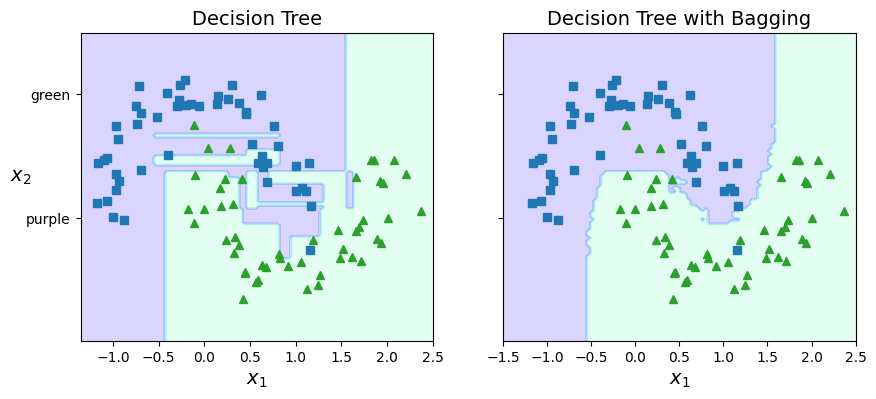

In [27]:
# Plot BeggingClassifier and DecisionTreeClassifier
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Tree with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

Since with bagging method not all instances are selected for training (only about 63%), out-of-bag instances can be used for model evaluation.

In [28]:
# Out-of-bag evaluation
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                           bootstrap=True, oob_score=True, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

Since `predict_proba()` method is available the `decision_function_` returns the class probabilities.

In [29]:
bag_clf.oob_decision_function_

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06145251, 0.93854749],
       [0.35465116, 0.64534884],
       [0.01142857, 0.98857143],
       [0.98930481, 0.01069519],
       [0.97927461, 0.02072539],
       [0.75586854, 0.24413146],
       [0.0049505 , 0.9950495 ],
       [0.75520833, 0.24479167],
       [0.82122905, 0.17877095],
       [0.98461538, 0.01538462],
       [0.06315789, 0.93684211],
       [0.00490196, 0.99509804],
       [0.99004975, 0.00995025],
       [0.92513369, 0.07486631],
       [1.        , 0.        ],
       [0.03409091, 0.96590909],
       [0.35087719, 0.64912281],
       [0.91111111, 0.08888889],
       [1.        , 0.        ],
       [0.96319018, 0.03680982],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.6635514 , 0.3364486 ],
       [0.

According to `oob_score_` the `BaggingClassifier` can achive 89.6% accuracy on the test set that is similar to what we got.

In [30]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92